To do

    establish a ratio cut off
    find ways to analyse higher vmags

What this code does

The code bellow imports all the data provided by TSM into two arrays one containing all the data of the stars frequency power specturm the other conatining the vmag andvmax of each star. The vmag will be used in calculation as it can be caulculated by Plato. The vmax will only be used to compare our final results to the the true value to evaluate if our code is working.

This code can calculated the vamx of a given number of stars if the stars vmag is also provided. We data raw data from the TSM team which does not have noise added to it. The process the data undergoes is as follows. Random noise is added to simulate realistic data, The data is then binned to remove the small rapid changes of the noise but preserve the larger overall shape. A curve is then fit to the background of the data. This background is then subtracted from the data overall to produce a roughly flat line. A gaussian is then fitted over the flattened data, this gaussian should fit to the envelope of p modes produced by the star. This whole process is repeated a given number of times (currently set to 100) the noise is added seperatly each time this is done to reduce the effect of the random noise. The vamx calculated for every trail and all the results are averaged to find the average vamx for that given star. This average vmax is also compared to the true vmax given by the TSM team.

The code returns a set of subplots for each of the stars, the subplots area as follows:

    The raw data from the TSM team
    The data with noise added to it
    The data after being binned and a background fit shown
    The data flattened after having the background fit subtracted from it
    The data with a gaussian fitted around the envelope
    A cropped version of the graph in subplot 5, cropped around the true value of vamx

The code also calculates the area under the background of the frequency power spectrum and the area under the fitted gaussian envelope. The code then calculates a ratio of the areas to determine the strength of the detection.

The code then plots a graph showing how the distance between the true vamx and the calculated vmax changes with the vmag of the star. A line of bets fit is then calculated for this plot and is shown on the graph, The equation of this line is shown bellow.

In [1]:
import numpy as np
import pandas as pd
import astropy.constants as c

import scipy
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.integrate import quad
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths

import math
from statistics import stdev

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='serif')

In [2]:
'''Imports data'''
#folderpath = "/home/luke740/Documents/Y3 (S2) Asteroseismology Group Studies/Code Scripts/Data/"
#"ypoints(27-02).txt" 
#filename = "Kypoints50_(28-02).txt" #"" "Mypoints.txt"
#filename1 = "Kotherstuff50_(28-02).txt" #""  "Motherstuff.txt"

#filepath = str(folderpath) + str(filename)
#print(filepath)
#filepath1 = str(folderpath) + str(filename1)
#print(filepath1)

#Kypoints.txt
#Kotherstuff.txt
#
#
#Kypointsrange(51, 61).txt
#Kotherstuffrange(51, 61).txt

data = np.genfromtxt('Kypointsrange(0, 20)_(13-03-20).txt', delimiter=' ') #importing power and frequency data
print(np.shape(data))
extradata = np.genfromtxt('Kotherstuffrange(0, 20)_(13-03-20).txt', delimiter=' ') #importing vmax and vmag for each star
print(np.shape(extradata))
'''
data = np.genfromtxt('Kypointsrange(20, 40)_(13-03-20).txt', delimiter=' ')
print(np.shape(data))
extradata = np.genfromtxt('Kotherstuffrange(20, 40)_(13-03-20).txt', delimiter=' ')
print(np.shape(extradata))
'''

(21, 1261440)
(20, 5)


"\ndata = np.genfromtxt('Kypointsrange(20, 40)_(13-03-20).txt', delimiter=' ')\nprint(np.shape(data))\nextradata = np.genfromtxt('Kotherstuffrange(20, 40)_(13-03-20).txt', delimiter=' ')\nprint(np.shape(extradata))\n"

Bin_it

This function bins one array and reduces another array to match its length so they can be plotted together. This is done to reduce the noise whihc comes from the noise on the data.
Inputs

    yvalues: y array, the Power normally called Fulldata in this code
    xvalues: x array, the frequency
    binsize: the size of the bin the y values will be averaged in, every binsizeth value will also be taken from the x array
    ### Outputs
    Binned y array (Power)
    reduced x array (Frequency)



In [3]:
def bin_it(yvalues, xvalues, binsize):
    '''puts an array into averaged bins of a given size'''
    N=int(math.ceil(len(yvalues)/binsize))
    C=0
    newy=[]
    while C<N:
        if (C+1)*binsize<len(yvalues):
            Q=(np.sum(yvalues[C*binsize:(C+1)*binsize]))/binsize
        else:
            Q=(np.sum(yvalues[C*binsize:len(yvalues)]))/binsize
        newy.append(Q)
        C+=1
    y=np.array(newy)
    x=xvalues[0::binsize] 
    return y[0:len(y)-1], x[0:len(y)-1]

addnoise

adds noise to and array. The method used to generate the noise was taken from a recommended scientific paper
Input

    pure: orignal array ### output
    array with noise added



In [4]:
#Adds random noise
def addnoise(pure):
    vary = np.random.uniform(0, 1, pure.shape)
    signal = -(pure* np.log(vary))
    return signal

gausgran

Is the equation of a gaussian where the base is not just a flat line, it is adjusted by an array fitted to the background called fittedgran.
Inputs

    x: array over which the gaussian with background should be plotted
    height: Height of the gaussian
    centre: Centre of the gaussian
    width: Width of the gaussain at half its height ### Output
    An equation with gives a gaussian on a line fitted to the background of the data



In [5]:
def gausgran(x, height, centre, width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran


gaus

The equation of a gaussian.
Inputs

    x: array over which the gaussian with background should be plotted
    height: Height of the gaussian
    centre: Centre of the gaussian
    width: Width of the gaussain at half its height ### Output
    An equation with gives a gaussian



In [6]:
def gaus(x, height, centre, width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))


findgran

Finds an equation which describes the background noise of the initial data and returns the values needed to plot the background
Inputs

    x: x value array (frequency)
    y: y value arrat (power) ### Output
    best_vals is an array of to integers which can be put into graneq to fit the background noise



In [7]:
def findgran(x, y):
    #guess_vals=[np.max(y),y[round(len(y)/4)]]
    guess_vals=[0, 0]
    best_vals, covar =curve_fit(graneq, x, y, p0=guess_vals)
    return best_vals

graneq

plots returns the y values of the background if the x array and two constants are inserted
Inputs

    x: x array (frequency)
    A: constant calulated by findgran
    tau: constant calulated by findgran ### Output
    array of y values of the background

In [8]:
def graneq(x,A,tau,SN):
    '''equation to describe the background'''
    return A/(1+(2*np.pi*x*tau)**4)+SN

find_nearest

finds the value in an array closest to a given number and returns the values index in the array
Inputs

    array: array containing the values you want to test
    value: value which you want to find the nearest value of in the array ### Output
    index of the value in the array which is closest to the given number

In [9]:
def find_nearest(array, value):
    '''finds value closest to a given value in an array'''
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

In [10]:
'''Below are the equations for a straight line and an exponential line. 
Will be used for fitting a line of best fit for the final results'''
# STRAIGHT LINE #
def f(x,a,b):
    return a*x+b

# EXPONENTIAL LINE #
def f1(x,a,b,c):
    return a*np.exp(b*x)+c

In [11]:
def integrand1(x, a, b, c):
    I = a/(1+(2*np.pi*x*b)**4)+c
    return I

def integrand2(x,amplitude,centre,width):
    I = (amplitude**2)*(np.exp(-0.5*((x-centre)/width)**2))
    return I

vmaxplot

Finds the vmax of a given number of stars. Returns a subplot showing the steps taken by the code.
Inputs

    powerdata: The y values of a given star
    truevmax: The true vmax of a given star provided by TSM
    truevmag: The true vmag of a given star provided by TSM
    N: The number of trials for each star
    binsize: The bin size used in the binning step of the code
    Starnumber: The number of the star being tested used for the titles of graphs
    Want_subplot: If the code should return the subplots 'yes' subplots are wanted anything else will not return subplots ### Output
    difference: Returns the differnce between the truevmax and the fitted vmax for a given star

In [22]:
def vmaxplot(powerdata, truevmax, truevmag, Num, binsize, Starnumber, Want_subplot, center_guess, width_guess):
    frequency=data[0]
    C=0
    pos=0
    fails=0
    false_pos=0
    false_pos_1=0
    amps=[]
    centres=[]
    Int1s = []
    Int2s = []
    widths=[] #generated empty arrays to store the information of the envelope gaussian fits
    N = np.linspace(1, Num, Num)
    #print(N)
    
    while C < int(Num): #loops while the counting variable is less than a given number N
        y,x=bin_it(addnoise(powerdata), frequency, binsize) #adds noise and bins
        SN = 18*10**(-0.4*(11.0-truevmag)) #Calculates SN
        bounds_1=([0,0,SN-SN/100],[np.inf,np.inf,SN+SN/100])
        bv,covar =curve_fit(graneq, x, y, p0=[0,0,SN],bounds=bounds_1) 
        Int1s.append(quad(integrand1, frequency[0], frequency[-1], args=(bv[0],bv[1],bv[2]))[0])
        #finds equation for background. SN is inculded as a variable so it can different for every star. The bounds on SN 
        #are very narrow though so the curve fitting program can not change it too much.
        background=graneq(x,bv[0],bv[1],bv[2]) #calculates the background of the data
        fittedgran=background
        yflat= (y / fittedgran) - 1 #subtracts the background from the data
        #yflat=y-background
        p0=[1, center_guess, width_guess] #initial guesses for gaussian
        
        try:
            bounds_2=([0.0,3000,300],[np.inf,14000,np.inf])
            best_vals, covar = curve_fit(gaus, x, yflat, p0=p0,bounds=bounds_2) 
            #fits gaussian. bounds included since the centre of the peak must be in the data and the amp is not negative
            max_theoretical = 0.66*(truevmax)*0.88 
            #taken from eqn 19 of paper by Warwick, Chaplin et al Dec 2018
            #print(max_theoretical)
            #print(f'Fitted Width is {best_vals[2]} and maximum width is {max_theoretical}')
             
            if best_vals[2]< max_theoretical: #maximum theoretical width of gaussian envelope
                amps.append(best_vals[0])
                centres.append(best_vals[1])
                widths.append(best_vals[2])  
                Int2s.append(quad(integrand2, frequency[0], frequency[-1], args=(best_vals[0],best_vals[1],best_vals[2]))[0])
            #C+=1
            else: 
            #try and except are used incase the code can not fit a gaussian. 
            #try and expect stop the code from crashing
                false_pos_1+=1 #records a failure to fit a gaussain to the data
                C+=1
                
            G=gaus(x,np.mean(amps),np.mean(centres),np.mean(widths))
            diff=max(G)-min(G)
            HM=diff/2 # half maximum        
            pos_extremum=G.argmax()  # finds indices of max point (assumed to be peak or very near it)        
            nearest_above=(np.abs(G[pos_extremum:-1]-HM)).argmin()
            nearest_below=(np.abs(G[0:pos_extremum]-HM)).argmin()        
            FWHM=(np.mean(x[nearest_above+pos_extremum])-np.mean(x[nearest_below]))
            #print(FWHM)
            SD=FWHM/(2*(2*math.log(2))**0.5)
            #print(SD)
            #print(abs(average_v_max-truevmax)) 
            #print(f'len centres {len(centres)}')
            
            if abs(centres[int(C)]-truevmax)<SD:
                pos+=1 
                C+=1
            else:
                false_pos+=1
                C+=1
                #C+=1
        except:
            fails+=1
            C+=1
    print(f'{fails} failed to fit a gaussian to the data')
    print(f'{pos} detections made at vmag of {truevmag}')
    print(f'{false_pos} detections failed at vmag of {truevmag}')
    print(f'{false_pos_1} widths were above the maximum theoretical width')
    print(' ')
    
    if len(centres)>0: #included to prevent error is no peaks were detected
        average_v_max=np.mean(centres)
        difference=np.abs(average_v_max-truevmax)
        #print(difference)  
        
        if Want_subplot=='yes':
            print(f'{fails}/{len(N)} trails failed')
            print(f'average v_max {average_v_max} which is {difference} away from the true value of {truevmax}')
            ratio=np.mean(Int2s)/np.mean(Int1s)
            print(f' The first value for the power under the background is {Int1s[0]}')
            print(f' The first value for the power under the oscillation Gaussian is {Int2s[0]}')
            print(f' The mean power under the oscillation Gaussian for {len(N)} fits is {np.mean(Int2s)}')
            print(f'ratio of Gaussian to Background Power is {ratio}')
            print(f'ratio of Background to Gaussian Power is {1 / ratio}')
            print(f'times worse than base line {0.00011375652938425257/ratio}')
            
            #Code bellow plots sub plots tracking process of the analysis
            fig, axs  = plt.subplots(3, 2, figsize=(12,16))
            fig.suptitle(f'Star {int(Starnumber)} vmag: {truevmag}')
            axs[0,0].plot(frequency, powerdata, label='Data')
            axs[0,0].set_title('TSM Model Data')
            axs[0,0].set_xlabel('Frequency, [$\mu Hz$]', fontsize = 18)
            axs[0,0].set_ylabel('Power [$ppm^2\ \mu Hz^{-1}$]', fontsize = 18)
            axs[0,0].legend(fontsize=10)
            
            axs[0,1].plot(frequency, addnoise(powerdata), label='data')
            axs[0,1].set_title('Noisy Realisation of Model')
            axs[0,1].set_xlabel('Frequency, [$\mu Hz$]', fontsize = 18)
            axs[0,1].set_ylabel('Power [$ppm^2\ \mu Hz^{-1}$]', fontsize = 18)
            axs[0,1].legend(fontsize=10)
            
            axs[1,0].plot(x, y, label='Data')
            axs[1,0].plot(x, background, label='Fitted background')
            axs[1,0].axvline(truevmax, color='yellow', label=r'True $\nu_{max}$')
            axs[1,0].set_title(f'Binned Model (binsize: {binsize}) with background fitted')
            axs[1,0].set_xlabel('Frequency, [$\mu Hz$]', fontsize = 18)
            axs[1,0].set_ylabel('Power [$ppm^2\ \mu Hz^{-1}$]', fontsize = 18)
            axs[1,0].legend(fontsize=10)
            
            axs[1,1].plot(x, yflat, label='Data')
            axs[1,1].axhline(0, color='black')
            axs[1,1].set_title('Background removed from data')
            axs[1,1].set_xlabel('Frequency, [$\mu Hz$]', fontsize = 18)
            axs[1,1].set_ylabel('Power [$ppm^2\ \mu Hz^{-1}$]', fontsize = 18)
            axs[1,1].legend(fontsize=10)
            
            axs[2,0].plot(x, yflat, label='Data')
            axs[2,0].plot(x, gaus(x, np.mean(amps), np.mean(centres), np.mean(widths)), label='Fitted gaussian')
            axs[2,0].axvline(truevmax,color='yellow', label=r'True $\nu_{max}$')
            axs[2,0].axvline(average_v_max, color='purple', label=r'Fitted $\nu_{max}$')
            axs[2,0].axvline(center_guess,color='gray',linestyle='--',label='initial guess')
            axs[2,0].set_title('Fitted gaussian')
            axs[2,0].set_xlabel('Frequency, [$\mu Hz$]', fontsize = 18)
            axs[2,0].set_ylabel('Power [$ppm^2\ \mu Hz^{-1}$]', fontsize = 18)
            axs[2,0].legend(fontsize=10)
            
            bottom=find_nearest(x, truevmax-2500)
            top=find_nearest(x, truevmax+2500)
            xf=x[bottom:top]
            yflatf=yflat[bottom:top]#crops data down
            
            axs[2,1].plot(xf, yflatf,label='data')
            axs[2,1].plot(xf, gaus(xf, np.mean(amps), np.mean(centres), np.mean(widths)), label='Fitted gaussian')
            axs[2,1].axvline(truevmax, color='yellow', label=r'True $\nu_{max}$')
            axs[2,1].axvline(average_v_max, color='purple', label=r'Fitted $\nu_{max}$')
            axs[2,1].set_title('Cropped fitted gaussian')
            axs[2,1].set_xlabel('Frequency, [$\mu Hz$]', fontsize = 18)
            axs[2,1].set_ylabel('Power [$ppm^2\ \mu Hz^{-1}$]', fontsize = 18)
            axs[2,1].legend(fontsize=10)
            #plt.legend(fontsize = 10)
            #plt.tight_layout()
            plt.figtext(0.5, 0.07, f'{fails} iterations failed to fit a gaussian to the data', horizontalalignment='center')
            plt.figtext(0.5, 0.06, f'{pos} detections made that lie within 1 sigma of ' r'$\nu_{max}$ ' f'at vmag of {truevmag}', horizontalalignment='center')
            plt.figtext(0.5, 0.05, f'{false_pos} detections failed at vmag of {truevmag}', horizontalalignment='center')
            plt.figtext(0.5, 0.04, f'{(pos / len(N))*100:.2f} % detections made at visual magnitude of V = {truevmag}', horizontalalignment='center')
            plt.subplots_adjust(top=0.95, hspace=0.3)
            savename = 'K_dwarf_(24-03)_(CG_6000)_(BS_500)_(I_2000)' + str(20+n) + '.png'
            #plt.savefig('Code Plots (K dwarfs)/' + savename, overwrite = True)
            plt.show()
            print('-----------------------------------------------------------------------------------------------------------')
            
            #DTab = pd.DataFrame(np.array([Starnumber, truevmag, pos, fails, false_pos]), columns=['Star Number', 'Vmag', 'No. Detections', 'No. Failed Detections', 'No. False Positives'])
            #print(DTab)
        return centres, widths, difference, Starnumber
    else:
        print('fails')
        print('false_pos')
        plt.plot(x, y, label='data')
        plt.plot(x, background, label='background')
        plt.legend()
        plt.show()

How many stars do you want to analyse? pick an integer no larger than 20: 4
How many iterations do you want to run per star? 40
What binsize do you want to run ? 300
What value to you think the oscillations are centered around? 6000
What width (FWHM in muHz) do you think the oscillation envelope has350
Do you want subplots? (yes or no): yes
 
----------------------------------------------------------------------------------
 
0 failed to fit a gaussian to the data
24 detections made at vmag of 7.319
16 detections failed at vmag of 7.319
0 widths were above the maximum theoretical width
 
0/40 trails failed
average v_max 5512.524547970102 which is 668.9909706801018 away from the true value of 4843.53357729
 The first value for the power under the background is 15676.52634111956
 The first value for the power under the oscillation Gaussian is 0.18192976215091025
 The mean power under the oscillation Gaussian for 40 fits is 0.17015755036966795
ratio of Gaussian to Background Power is 1.08

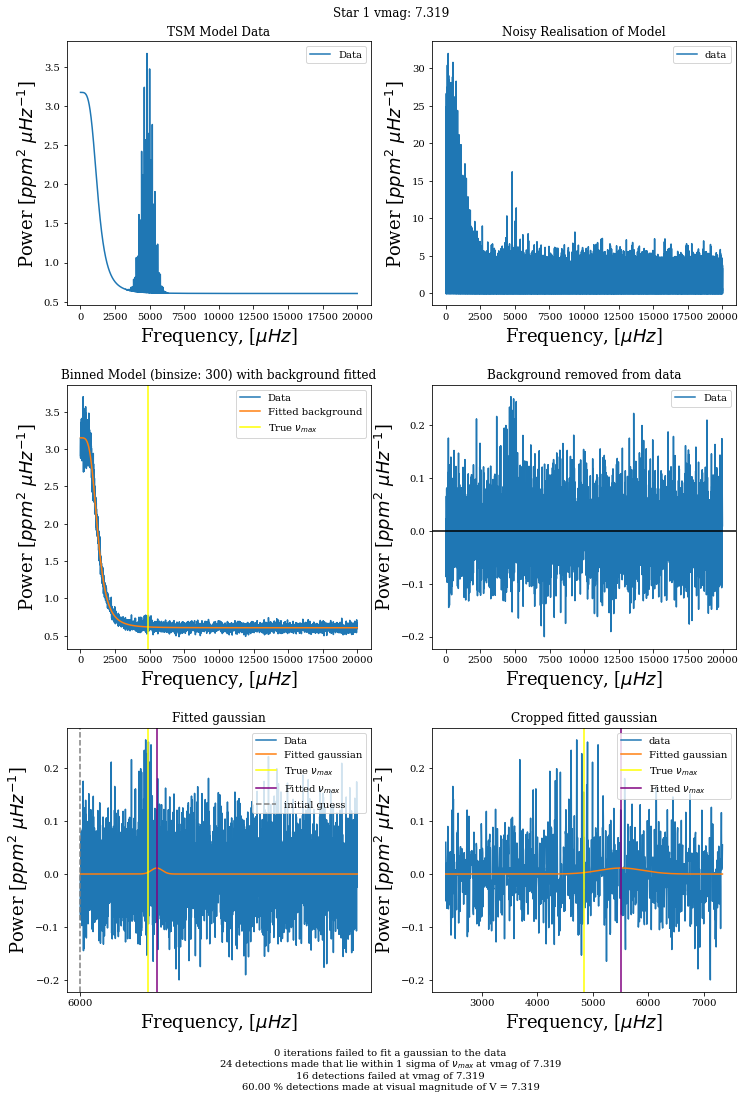

-----------------------------------------------------------------------------------------------------------
 
40
4962.155006570094
5015.556137537547
4851.20767356772
5511.239746849798
4906.216984594033
4816.802189250834
6296.375582900088
6127.703992515272
5165.035952120172
4963.347187495448
4685.821356745128
5157.936302101814
4897.640456333131
4904.191582468118
5054.722828890563
4672.5872069293955
4720.763576016748
3182.876194680209
4605.372845664628
5772.168886791725
4807.667112529771
4786.118285412112
4841.920447925313
5958.903327488298
5459.154974201556
6339.226992578252
4520.672290042561
4980.346060726551
6375.299046247778
5935.798225672895
6485.373062761907
6083.5901751828715
4761.4023611712055
4652.3779788810825
6617.362647352311
9466.187284914837
5976.31982228076
4860.447590069804
12343.267890856949
4979.82465248478
The centres of the fitted Gaussians are [4962.155006570094, 5015.556137537547, 4851.20767356772, 5511.239746849798, 4906.216984594033, 4816.802189250834, 6296.375582

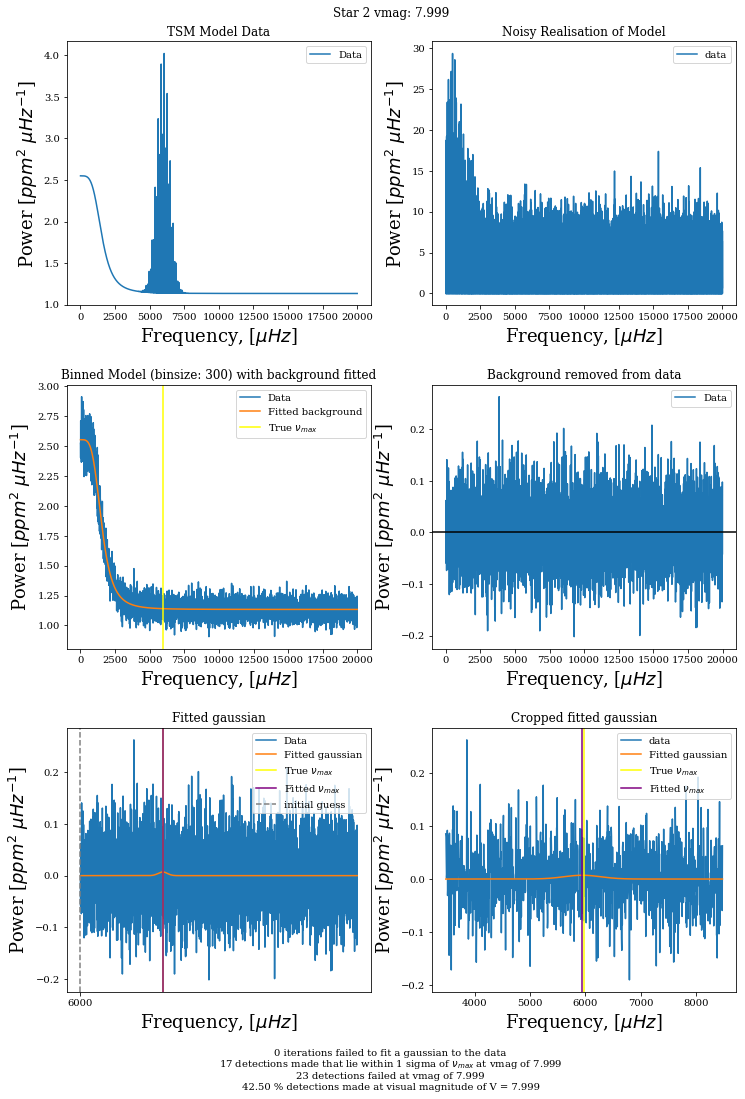

-----------------------------------------------------------------------------------------------------------
 
40
6010.974330061773


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [29]:
Number_of_star=input(f'How many stars do you want to analyse ? pick an integer no larger than {len(extradata[:,0])}: ')
num_trials = input('How many iterations do you want to run per star ? ')
Num = int(num_trials)
#print(Num)
binsize = input('What binsize do you want to run ? ')
center_guess=input('What value to you think the oscillations are centered around ? ')
width_guess=input('What width (FWHM in muHz) do you think the oscillation envelope has ? ')
Want_subplot=input('Do you want subplots? (yes or no): ')
print(' ')
print('----------------------------------------------------------------------------------')
print(' ')
centresarray=[]
widthsarray=[]
StarNosarray=[]
differences=[]
m=np.linspace(1,int(Number_of_star),int(Number_of_star))

for n in m:
    centres,widths,differences,Starnumbers = vmaxplot(data[int(n)], extradata[int(n)-1,1], extradata[int(n)-1,2], int(num_trials), int(binsize),n, Want_subplot, center_guess, width_guess)
    #print(vmaxplot(data[int(n)], extradata[int(n)-1,1], extradata[int(n)-1,2], int(num_trials), int(binsize),n, Want_subplot, center_guess, width_guess))
    print(' ')
    #print(centres)
    #print(' ')
    print(len(centres))
    for i in centres:
        print(i)
        centresarray.append(i)
    print(f'The centres of the fitted Gaussians are {centresarray}')
    for j in widths:
        widthsarray.append(j)
    print(f'The widths of the fitted Gaussians are {widthsarray}')
    StarNosarray.append(Starnumbers)
    print(f'Star-number array is {StarNosarray}')
    if n % 10 == 0:
        print(f'{int(n)}/{int(Number_of_star)} stars run')
        
    centresarray=np.array(centresarray)
    averagecentres=np.mean(centresarray)#, axis = 1)
    print(f'The average centre of ... iterations is {averagecentres}')
    
    vmaxs=extradata[:,1]
    vmaxs=vmaxs[0:int(Number_of_star)]
    
    differences=np.abs(averagecentres-vmaxs)
    variences=np.var(centresarray)#, axis = 1)

if len(differences)>0:
    
    #vmags=extradata[:,2]
    #vmags=vmags[0:int(Number_of_star)]
    #plt.plot(vmags,differences, label='Data')
    
    fig, axs  = plt.subplots(2, 2,figsize=(12,12))
    axs[0,0].plot(m, differences)
    axs[0,0].set_xlabel('Trial')
    axs[0,0].set_ylabel('Difference between true and fitted vmax')
    axs[0,0].set_title('Difference between true and fitted vmax for each trial')
    vmags=extradata[:,2]
    vmags=vmags[0:int(Number_of_star)]
    axs[0,1].plot(vmags,differences)
    axs[0,1].set_xlabel('vmag')
    axs[0,1].set_ylabel('Difference between true and fitted vmax')
    axs[0,1].set_title('Difference between true and fitted vmax against vmag')
    bvs, covar = curve_fit(f,m,differences,p0=[1,50])
    axs[1,0].plot(m,differences,label='Data')
    axs[1,0].plot(m,f(m,bvs[0],bvs[1]),label='Line of best fit')
    axs[1,0].set_xlabel('Trial')
    axs[1,0].set_ylabel('Difference between true and fitted vmax')
    axs[1,0].set_title('Difference between true and fitted vmax for each trial')
    axs[1,0].legend()
    try:
        bvs1, covar = curve_fit(f1,vmags,differences,p0=[1,1,150])
    except:
        bvs1, covar = curve_fit(f,vmags,differences,p0=[1,150])
    axs[1,1].plot(vmags,differences,label='Data')
    if len(bvs1)>2:
        axs[1,1].plot(vmags,f1(vmags, bvs1[0],bvs1[1],bvs1[2]),label='Line of best fit')
    else:
        axs[1,1].plot(vmags,f(vmags, bvs1[0],bvs1[1]),label='Line of best fit')
    axs[1,1].set_xlabel('vmag')
    axs[1,1].set_ylabel('Difference between true and fitted vmax')
    axs[1,1].set_title('Difference between true and fitted vmax for each vmag')
    axs[1,1].legend()
    plt.show()
    print(f'Equation of line of best fit for trail against difference: {bvs[0]}*x+{bvs[1]}')
    print('')
    if len(bvs1)>2:
        print(f'Equation of line of best fit for vmag against difference: {bvs1[0]}*e^({bvs1[1]}*x){bvs1[2]}')
    else:
        
        print(f'Equation of line of best fit for vmag against difference: {bvs1[0]}*x{bvs1[1]}')

    if len(variences)>0:
        plt.plot(vmags,variences, label='Data')
        plt.axhline(0, color='black', linestyle='--')
    try:
        bvs1, covar = curve_fit(f1,vmags,variences,p0=[0,0,0])
    except:
        bvs1, covar = curve_fit(f,vmags,variences,p0=[0,0])
    if len(bvs1)>2:
        plt.plot(vmags,f1(vmags,bvs1[0],bvs1[1],bvs1[2]),label='Line of best fit')
    else:
        plt.plot(vmags,f(vmags,bvs1[0],bvs1[1]),label='Line of best fit')
    plt.xlabel('vmag')
    plt.ylabel('Varience of vmax values')
    plt.title('Varience of vmax values against vmag')
    plt.legend(fontsize = 16)
    plt.show()
    if len(bvs1)>2:
        print(f'Equation of line of best fit for vmag against varience: {bvs1[0]}*e^({bvs1[1]}*x){bvs1[2]}')
    else:
        print(f'Equation of line of best fit for vmag against varience: {bvs1[0]}*x{bvs1[1]}')


In [ ]:
'''TESTING'''
numax = 9500
max_theoretical = 0.66*(numax)*0.88
print(max_theoretical)

N = np.linspace(1, 100, 100)
print(N)

In [ ]:
import pandas as pd

DTab = pd.DataFrame(np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]), columns=['Star Number', 'Vmag', 'No. Detections', 'No. Failed Detections', 'No. False Positives'])
print(DTab)

In [ ]:
number_of_centre_guesses=30
N=50

frequency=data[0]
centre_guesses=np.linspace(3000, 8000, number_of_centre_guesses)
Stars=np.linspace(1,len(extradata[:,1]),len(extradata[:,1]))
centresallstars=[]
for m in Stars:
    centres=[]
    StarNo=int(m)
    StarNo=int(StarNo)
    for n in centre_guesses:
        hold,trash1,trash2=vmaxplot(data[StarNo],extradata[StarNo-1,1],extradata[StarNo-1,2],N,6000,StarNo,'no',centre_guess=int(n))
        centres.append(hold)
    centres=np.array(centres)
    centresallstars.append(centres)
    if m % 5 ==0:
        print(f'{m}/{int(len(extradata[:,1]))} stars complete')
centresallstars=np.array(centresallstars)
with open(f'Stars {len(Stars)} centre guess {number_of_centre_guesses} trials {N}', 'w') as outfile:
    for n in Stars:
        np.savetxt(outfile,centresallstars[int(n)-1], delimiter=' ')

In [ ]:
G=np.genfromtxt(f'Stars {len(Stars)} centre guess {number_of_centre_guesses} trials {N}',delimiter=' ')
G=np.array(G)
centresallstars=G.reshape((len(Stars),number_of_centre_guesses,N))

In [ ]:
Stars=np.linspace(1,len(extradata[:,1]),len(extradata[:,1]))
#Stars=np.linspace(1,10,10)
yes=[]
no=[]
maybe=[]
for n in Stars:
    StarNo=int(n)
    centres=centresallstars[StarNo-1]
    plt.plot(centre_guesses,np.mean(centres,axis=1))
    #plt.axhline(extradata[StarNo-1,1],label='true vmax',color='red')
    plt.plot(centre_guesses,centre_guesses,color='grey',linestyle='--',label='y=x line')
    plt.xlabel('initial guess')
    plt.ylabel('calculated vamx')
    plt.title(f'Star: {StarNo}')
    plt.legend()
    plt.show()
    answer=input('yes(y), no(n) or maybe(m): ')
    if answer=='y':
        yes.append([extradata[StarNo-1,1],extradata[StarNo-1,2]])
    if answer=='n':
        no.append([extradata[StarNo-1,1],extradata[StarNo-1,2]])
    if answer=='m':
        maybe.append([extradata[StarNo-1,1],extradata[StarNo-1,2]])
yes=np.array(yes)
no=np.array(no)
maybe=np.array(maybe)

In [ ]:
plt.scatter(yes[:,0],yes[:,1],color='green',label='definite detections')
plt.scatter(maybe[:,0],maybe[:,1],color='orange',label='possible detections')
plt.scatter(no[:,0],no[:,1],color='red',label='no detection')
plt.xlabel('Vmax')
plt.ylabel('Vmag')
plt.title('Detectablity of different stars at various Vmags and Vmaxs ')
plt.legend()
plt.show()